Imports

In [396]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
import joblib
from typing import Tuple
import warnings
from scipy import stats
from scipy.fft import fft
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Data Loading and Batching

In [397]:
class DataLoader:
    def __init__(self, train_split, random_state, batch_size):
        self.train_split = train_split
        self.random_state = random_state
        self.batch_size = batch_size
        self.all_data = None
        self.all_labels = None
        self.file_metadata = None
        self.train_files = None
        self.test_files = None
        self.train_batches = None
        self.test_batches = None
        self.train_batch_labels = None
        self.test_batch_labels = None

    def load_all_data(self, train_dir: str, test_dir: str) -> None:
        all_file_data = {}
        
        for directory, dir_type in [(train_dir, 'original_train'), (test_dir, 'original_test')]:
            if not os.path.exists(directory):
                continue

            for folder in sorted(os.listdir(directory)):
                folder_path = os.path.join(directory, folder)
                if not os.path.isdir(folder_path):
                    continue

                for file in os.listdir(folder_path):
                    if not file.endswith('.csv'):
                        continue

                    file_path = os.path.join(folder_path, file)
                    df = pd.read_csv(file_path, encoding="ISO-8859-1")
                    file_id = f"{dir_type}_{folder}_{file.replace('.csv', '')}"
                    
                    all_file_data[file_id] = {
                        'data': df,
                        'label': folder,
                        'file_path': file_path,
                        'original_source': dir_type,
                        'activity': folder
                    }

        self.file_metadata = all_file_data
        print(f"Total files: {len(self.file_metadata)}")
        print(f"Activities: {sorted(set([meta['activity'] for meta in self.file_metadata.values()]))}")
        
        self._analyze_file_distribution()
        self._create_batches()

    def _analyze_file_distribution(self):
        print("\nFile distribution per activity:")
        activity_stats = {}
        
        for file_id, meta in self.file_metadata.items():
            activity = meta['activity']
            if activity not in activity_stats:
                activity_stats[activity] = {'files': 0, 'total_samples': 0}
            
            activity_stats[activity]['files'] += 1
            activity_stats[activity]['total_samples'] += len(meta['data'])
        
        for activity in sorted(activity_stats.keys()):
            stats = activity_stats[activity]
            print(f"{activity}: {stats['files']} files, {stats['total_samples']} samples")
        
        total_files = sum([stats['files'] for stats in activity_stats.values()])
        total_samples = sum([stats['total_samples'] for stats in activity_stats.values()])
        print(f"Total: {total_files} files, {total_samples} samples")

    def _create_batches(self):
        print(f"\nCreating batches with batch_size={self.batch_size}")
        
        all_batches = []
        all_batch_labels = []
        batch_file_mapping = []
        
        for file_id, meta in self.file_metadata.items():
            df = meta['data'].copy()
            label = meta['label']
            
            cols_to_exclude = ['Unnamed: 0', 'time', 'target']
            feature_cols = [col for col in df.columns if col not in cols_to_exclude]

            features = df[feature_cols].dropna()
            
            if len(features) == 0:
                continue
            
            n_complete_batches = len(features) // self.batch_size
            
            if n_complete_batches == 0:
                print(f"File {file_id}: {len(features)} samples - No complete batches (skipped)")
                continue
            
            print(f"File {file_id}: {len(features)} samples -> {n_complete_batches} batches")
            
            for batch_idx in range(n_complete_batches):
                start_idx = batch_idx * self.batch_size
                end_idx = start_idx + self.batch_size
                batch_data = features.iloc[start_idx:end_idx].values
            
                aggregated_batch = np.concatenate([
                    np.mean(batch_data, axis=0),
                    np.std(batch_data, axis=0),
                    np.min(batch_data, axis=0),
                    np.max(batch_data, axis=0)
                ])

                all_batches.append(aggregated_batch)
                all_batch_labels.append(label)
                batch_file_mapping.append(file_id)        
        self.all_batches = np.array(all_batches)
        self.all_batch_labels = np.array(all_batch_labels)
        self.batch_file_mapping = batch_file_mapping
        
        print(f"\nTotal batches created: {len(self.all_batches)}")
        print(f"Batch feature dimension: {self.all_batches.shape[1] if len(self.all_batches) > 0 else 0}")

    def split_by_files(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        if self.all_batches is None or len(self.all_batches) == 0:
            raise ValueError("No batches created. Check if data was loaded properly.")

        all_files = list(self.file_metadata.keys())
        np.random.seed(self.random_state)
        np.random.shuffle(all_files)

        n_train_files = int(len(all_files) * self.train_split)
        self.train_files = all_files[:n_train_files]
        self.test_files = all_files[n_train_files:]

        print(f"\nTrain files: {len(self.train_files)}")
        print(f"Test files: {len(self.test_files)}")

        train_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.train_files]
        test_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.test_files]

        X_train = self.all_batches[train_indices]
        X_test = self.all_batches[test_indices]
        y_train = self.all_batch_labels[train_indices]
        y_test = self.all_batch_labels[test_indices]

        self.train_batches = X_train
        self.test_batches = X_test
        self.train_batch_labels = y_train
        self.test_batch_labels = y_test

        print(f"Train batches: {len(X_train)}")
        print(f"Test batches: {len(X_test)}")

        self._check_activity_distribution_batches(train_indices, test_indices)

        return X_train, X_test, y_train, y_test

    def _check_activity_distribution_batches(self, train_indices, test_indices):
        train_activities = set(self.all_batch_labels[train_indices])
        test_activities = set(self.all_batch_labels[test_indices])
        all_activities = set(self.all_batch_labels)

        print(f"Train activities: {sorted(train_activities)}")
        print(f"Test activities: {sorted(test_activities)}")

        if all_activities - train_activities:
            print(f"Missing in train: {sorted(all_activities - train_activities)}")
        if all_activities - test_activities:
            print(f"Missing in test: {sorted(all_activities - test_activities)}")

        print("\nBatch distribution per activity:")
        for activity in sorted(all_activities):
            train_count = np.sum(self.all_batch_labels[train_indices] == activity)
            test_count = np.sum(self.all_batch_labels[test_indices] == activity)
            print(f"{activity}: {train_count} train batches, {test_count} test batches")

    def load_data(self, root_dir: str) -> Tuple[np.ndarray, np.ndarray]:
        if root_dir.lower() == 'train':
            if self.train_batches is None:
                raise ValueError("Call get_train_test_split first.")
            return self.train_batches, self.train_batch_labels
        elif root_dir.lower() == 'test':
            if self.test_batches is None:
                raise ValueError("Call get_train_test_split first.")
            return self.test_batches, self.test_batch_labels
        else:
            raise ValueError("Invalid root_dir. Use 'train' or 'test'.")

    def get_train_test_split(self, train_dir: str = 'data_received/recorded_data_12344', test_dir: str = 'data_received/recorded_data_12345') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        self.load_all_data(train_dir, test_dir)
        return self.split_by_files()

loader = DataLoader(train_split=0.8, random_state=40, batch_size=44)
X_train_batches, X_test_batches, y_train_batches, y_test_batches = loader.get_train_test_split('data_received/recorded_data_12344', 'data_received/recorded_data_12345')

print(f"\nFinal Results:")
print(f"Train batches shape: {X_train_batches.shape}")
print(f"Test batches shape: {X_test_batches.shape}")
print(f"Features per batch: {X_train_batches.shape[1] if len(X_train_batches) > 0 else 0}")
print(f"Classes: {len(np.unique(y_train_batches)) if len(y_train_batches) > 0 else 0}")

Total files: 136
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']

File distribution per activity:
idle: 16 files, 15347 samples
with_hook_climbing_up: 24 files, 12223 samples
with_hook_descending_down: 25 files, 14334 samples
without_hook_climbing_up: 36 files, 14405 samples
without_hook_descending_down: 35 files, 13548 samples
Total: 136 files, 69857 samples

Creating batches with batch_size=44
File original_train_idle_18062025_114823_12344_2: 594 samples -> 13 batches
File original_train_idle_18062025_114949_12344_3: 835 samples -> 18 batches
File original_train_idle_18062025_115127_12344_4: 1290 samples -> 29 batches
File original_train_idle_18062025_115503_12344_5: 835 samples -> 18 batches
File original_train_idle_18062025_115754_12344_6: 1076 samples -> 24 batches
File original_train_idle_18062025_121814_12344_7: 737 samples -> 16 batches
File original_train_idle_18062025_141135_12344_7: 710 sa

Preprocessing

In [398]:
class DataProcessor:
    def __init__(self, random_state: int = 43):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def fit_transform_train(self, X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"\nProcessing training data:")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

        if np.isnan(X_train).any():
            print("Warning: NaN values found in training data, filling with 0")
            X_train = np.nan_to_num(X_train, 0)

        shuffled_indices = shuffle(range(len(X_train)), random_state=self.random_state)
        X_shuffled = X_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]

        y_encoded = self.label_encoder.fit_transform(y_shuffled)
        X_scaled = self.scaler.fit_transform(X_shuffled)
        
        print(f"Processed X_train shape: {X_scaled.shape}")
        print(f"Unique classes: {len(np.unique(y_encoded))}")
        
        return X_scaled, y_shuffled

    def transform_test(self, X_test: np.ndarray, y_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"\nProcessing testing data:")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        if np.isnan(X_test).any():
            print("Warning: NaN values found in testing data, filling with 0")
            X_test = np.nan_to_num(X_test, 0)

        X_scaled = self.scaler.transform(X_test)
        
        print(f"Processed X_test shape: {X_scaled.shape}")
        
        return X_scaled, y_test

processor = DataProcessor()

processor = DataProcessor()

if len(X_train_batches) > 0 and len(X_test_batches) > 0:
    X_train_processed, y_train_processed = processor.fit_transform_train(X_train_batches, y_train_batches)
    X_test_processed, y_test_processed = processor.transform_test(X_test_batches, y_test_batches)

    print(f"\nFinal processed shapes:")
    print(f"Processed X_train: {X_train_processed.shape}")
    print(f"Processed X_test: {X_test_processed.shape}")
else:
    print("No batches created - check your data and batch_size parameters")


Processing training data:
X_train shape: (1182, 40), y_train shape: (1182,)
Processed X_train shape: (1182, 40)
Unique classes: 5

Processing testing data:
X_test shape: (335, 40), y_test shape: (335,)
Processed X_test shape: (335, 40)

Final processed shapes:
Processed X_train: (1182, 40)
Processed X_test: (335, 40)


Feature Extraction

In [399]:
def extract_statistical_features(X):
    features = np.column_stack([
        np.mean(X, axis=1), np.std(X, axis=1), np.var(X, axis=1),
        np.median(X, axis=1), np.min(X, axis=1), np.max(X, axis=1),
        np.percentile(X, 25, axis=1), np.percentile(X, 75, axis=1),
        stats.skew(X, axis=1), stats.kurtosis(X, axis=1)
    ])
    return features

def extract_frequency_features(X):
    fft_vals = np.abs(fft(X, axis=1))
    n_half = X.shape[1] // 2
    fft_vals = fft_vals[:, :n_half]
    
    features = np.column_stack([
        np.sum(fft_vals, axis=1), np.mean(fft_vals, axis=1),
        np.std(fft_vals, axis=1), np.max(fft_vals, axis=1)
    ])
    return features

def extract_temporal_features(X):
    zero_crossings = np.sum(np.diff(np.sign(X), axis=1) != 0, axis=1)
    first_diff = np.diff(X, axis=1)
    
    features = np.column_stack([
        zero_crossings,
        np.mean(first_diff, axis=1),
        np.std(first_diff, axis=1),
        np.sum(X**2, axis=1)
    ])
    return features

def extract_all_features(X):
    stat_features = extract_statistical_features(X)
    freq_features = extract_frequency_features(X)
    temp_features = extract_temporal_features(X)
    return np.column_stack([stat_features, freq_features, temp_features])

In [400]:
X_train_rf_features = extract_all_features(X_train_processed)
X_test_rf_features = extract_all_features(X_test_processed)

print(f"[Random Forest] Training features extracted: {X_train_rf_features.shape}")
print(f"[Random Forest] Test features extracted: {X_test_rf_features.shape}")

X_train_rf_combined = np.column_stack([X_train_processed, X_train_rf_features])
X_test_rf_combined = np.column_stack([X_test_processed, X_test_rf_features])

X_train_rf_combined = np.nan_to_num(X_train_rf_combined, nan=0.0, posinf=1e6, neginf=-1e6)
X_test_rf_combined = np.nan_to_num(X_test_rf_combined, nan=0.0, posinf=1e6, neginf=-1e6)

print(f"[Random Forest] Training features: {X_train_rf_combined.shape}")
print(f"[Random Forest] Test features: {X_test_rf_combined.shape}")

[Random Forest] Training features extracted: (1182, 18)
[Random Forest] Test features extracted: (335, 18)
[Random Forest] Training features: (1182, 58)
[Random Forest] Test features: (335, 58)


Feature Naming

In [401]:
original_feature_names = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'p']
stat_feature_names = ['Mean', 'Std', 'Variance', 'Median', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Skewness', 'Kurtosis']
freq_feature_names = ['FFT Sum', 'FFT Mean', 'FFT Std', 'FFT Max']
temp_feature_names = ['Zero Crossings', 'First Diff Mean', 'First Diff Std', 'Signal Energy']

extracted_feature_names = stat_feature_names + freq_feature_names + temp_feature_names 

all_feature_names = original_feature_names + extracted_feature_names

print("Feature Index:")
for i, name in enumerate(all_feature_names):
    print(f"{i:2d}: {name}")

Feature Index:
 0: ax
 1: ay
 2: az
 3: gx
 4: gy
 5: gz
 6: mx
 7: my
 8: mz
 9: p
10: Mean
11: Std
12: Variance
13: Median
14: Min
15: Max
16: 25th Percentile
17: 75th Percentile
18: Skewness
19: Kurtosis
20: FFT Sum
21: FFT Mean
22: FFT Std
23: FFT Max
24: Zero Crossings
25: First Diff Mean
26: First Diff Std
27: Signal Energy


Feature Selection and Scaling (GRF)

In [402]:
base_rf = RandomForestClassifier(n_estimators=100, random_state=43, n_jobs=-1)
base_rf.fit(X_train_rf_combined, y_train_processed)
initial_importances_rf = base_rf.feature_importances_

gamma_rf = 0.5
guided_importances_rf = gamma_rf * initial_importances_rf

threshold_rf = np.median(guided_importances_rf)
selector_rf = SelectFromModel(base_rf, threshold=threshold_rf, prefit=True)

X_train_rf_selected = selector_rf.transform(X_train_rf_combined)
X_test_rf_selected = selector_rf.transform(X_test_rf_combined)

print(f"[RF] Features selected: {X_train_rf_selected.shape[1]}")

selected_mask_rf = selector_rf.get_support()
selected_feature_names_rf = [name for i, name in enumerate(all_feature_names) if selected_mask_rf[i]]
print("[RF] Selected features:", selected_feature_names_rf)

scaler_rf = StandardScaler()
X_train_rf_final = scaler_rf.fit_transform(X_train_rf_selected)
X_test_rf_final = scaler_rf.transform(X_test_rf_selected)

[RF] Features selected: 53
[RF] Selected features: ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'p', 'Mean', 'Std', 'Variance', 'Median', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Skewness', 'Kurtosis', 'FFT Sum', 'FFT Mean', 'FFT Std', 'FFT Max', 'Zero Crossings', 'First Diff Mean', 'First Diff Std', 'Signal Energy']


Model

Random Forest

In [403]:
# model_rf = RandomForestClassifier(
#     n_estimators=40,
#     criterion='log_loss',                  
#     max_depth=None,
#     min_samples_split=5,
#     min_samples_leaf=3,
#     min_weight_fraction_leaf=0.0,
#     max_features=None,
#     max_leaf_nodes=50,
#     min_impurity_decrease=0.0,
#     bootstrap=True,
#     oob_score=False,
#     n_jobs=-1,
#     random_state=52,                       
#     verbose=0,
#     warm_start=False,
#     class_weight='balanced',              
#     ccp_alpha=0.0,
#     max_samples=0.7
# )

model_rf = RandomForestClassifier(
    n_estimators=40,
    criterion='log_loss',
    max_depth=10,                       # ✴️ Limit depth for generalization
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',               # ✴️ Add randomness, reduce variance
    max_leaf_nodes=50,
    bootstrap=True,
    oob_score=True,                    # ✴️ Monitor out-of-bag score
    n_jobs=-1,
    random_state=52,
    class_weight='balanced',
    max_samples=0.7
)



model_rf.fit(X_train_rf_final, y_train_processed)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_leaf_nodes=50, max_samples=0.7,
                       min_samples_leaf=3, min_samples_split=5, n_estimators=40,
                       n_jobs=-1, oob_score=True, random_state=52)

Evaluation and Metrics

In [404]:
from collections import Counter
print(f"Predicted label distribution: {Counter(y_pred_val)}")

from collections import Counter
print("Validation label distribution:", Counter(y_true))


Predicted label distribution: Counter({np.str_('with_hook_descending_down'): 54, np.str_('with_hook_climbing_up'): 1})
Validation label distribution: Counter({np.int64(0): 26, np.int64(1): 10, np.int64(2): 9, np.int64(3): 5, np.int64(4): 5})


In [405]:
y_pred_rf = model_rf.predict(X_test_rf_final)
accuracy_rf = accuracy_score(y_test_processed, y_pred_rf)
cm_rf = confusion_matrix(y_test_processed, y_pred_rf)
classification_rep_rf = classification_report(y_test_processed, y_pred_rf, output_dict=True)

print("Random Forest Model Performance")
print(f"Test Accuracy: {accuracy_rf:.6f}")
print(f"Test Samples: {len(y_test_processed):,}")

results_df_rf = pd.DataFrame(classification_rep_rf).transpose()
print("\nClassification Report (Random Forest):")
print(results_df_rf.round(4))

Random Forest Model Performance
Test Accuracy: 0.859701
Test Samples: 335

Classification Report (Random Forest):
                              precision  recall  f1-score   support
idle                             1.0000  0.9549    0.9769  133.0000
with_hook_climbing_up            0.7302  0.7797    0.7541   59.0000
with_hook_descending_down        0.7705  0.7833    0.7769   60.0000
without_hook_climbing_up         0.6500  0.9286    0.7647   28.0000
without_hook_descending_down     0.9545  0.7636    0.8485   55.0000
accuracy                         0.8597  0.8597    0.8597    0.8597
macro avg                        0.8210  0.8420    0.8242  335.0000
weighted avg                     0.8747  0.8597    0.8630  335.0000


Validation

Data Loading and Batching

In [406]:
DATA_PARENT_DIR = "data_received_v"
VAL_DIRS = ["recorded_data_12344", "recorded_data_12345"]

val_loader = DataLoader(train_split=0, random_state=40, batch_size=59)
for folder in VAL_DIRS:
    full_path = os.path.join(DATA_PARENT_DIR, folder)
    val_loader.load_all_data("__dummy__", full_path)

combined_array = np.vstack(val_loader.all_batches)
X_base = combined_array  # 10 features per batch (already dropped 'time' earlier)
y_true = np.array(val_loader.all_batch_labels)

if X_base is None or len(X_base) == 0:
    raise ValueError("No valid batches created from input files.")

print("Shape of X_base:", X_base.shape)
print("Unique true labels:", np.unique(y_true))

Total files: 10
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']

File distribution per activity:
idle: 2 files, 2136 samples
with_hook_climbing_up: 2 files, 1143 samples
with_hook_descending_down: 2 files, 877 samples
without_hook_climbing_up: 2 files, 662 samples
without_hook_descending_down: 2 files, 675 samples
Total: 10 files, 5493 samples

Creating batches with batch_size=59
File original_test_idle_18062025_114823_12344_2: 594 samples -> 10 batches
File original_test_idle_18062025_142205_12344_9: 1542 samples -> 26 batches
File original_test_with_hook_climbing_up_18062025_114547_12344_1: 535 samples -> 9 batches
File original_test_with_hook_climbing_up_18062025_141758_12344_13: 608 samples -> 10 batches
File original_test_with_hook_descending_down_18062025_114910_12344_1: 544 samples -> 9 batches
File original_test_with_hook_descending_down_18062025_143248_12344_14: 333 samples -> 5 batches
File

RF

In [407]:
# Step 1: Extract same features as in training
X_new_feat_rf = extract_all_features(X_base)

# Step 2: Combine raw + derived features
X_new_comb_rf = np.column_stack([X_base, X_new_feat_rf])
X_new_comb_rf = np.nan_to_num(X_new_comb_rf, nan=0.0, posinf=1e6, neginf=-1e6)

# Step 3: Feature selection
X_new_sel_rf = selector_rf.transform(X_new_comb_rf)

# Step 4: Scaling
X_new_fin_rf = scaler_rf.transform(X_new_sel_rf)

# Step 5: Prediction
y_pred_rf = model_rf.predict(X_new_fin_rf)

# Step 6: Label encoding (if needed)
# Ensure y_true matches training label encoding (skip re-encoding if already integer)
if isinstance(y_true[0], str):
    y_true = processor.label_encoder.transform(y_true)
else:
    print("✅ y_true already encoded. Skipping transformation.")
if isinstance(y_pred_rf[0], str):
    y_pred_rf = processor.label_encoder.transform(y_pred_rf)

# Step 7: Evaluation
acc_rf = accuracy_score(y_true, y_pred_rf)
print("Validation Performance - Random Forest")
print(f"Accuracy: {acc_rf:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_pred_rf, digits=4))

# Step 8: Confusion matrix and report
cm_rf_val = confusion_matrix(y_true, y_pred_rf)
classification_rep_rf_val = classification_report(y_true, y_pred_rf, output_dict=True)
results_df_rf_val = pd.DataFrame(classification_rep_rf_val).transpose()

Validation Performance - Random Forest
Accuracy: 0.2553
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        36
           1     0.3846    0.2632    0.3125        19
           2     0.3000    0.6667    0.4138        18
           3     0.1750    0.7000    0.2800        10
           4     0.0000    0.0000    0.0000        11

    accuracy                         0.2553        94
   macro avg     0.1719    0.3260    0.2013        94
weighted avg     0.1538    0.2553    0.1722        94



Visualization

Top 10 Important Features

IndexError: list index out of range

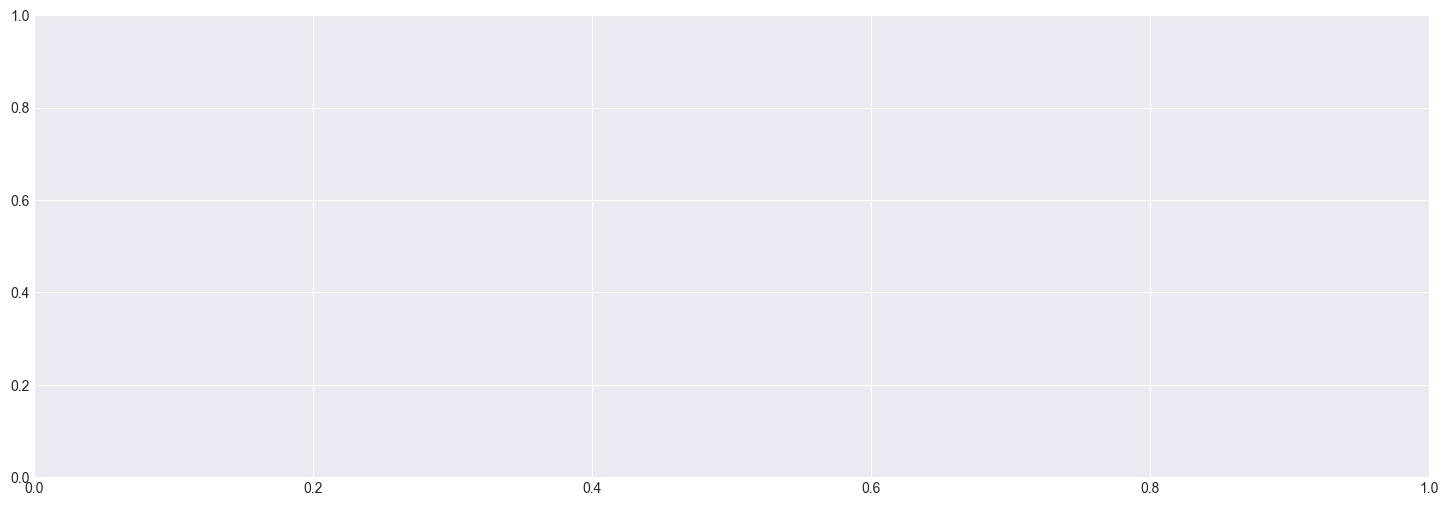

In [393]:
fig, axes = plt.subplots(figsize=(18, 6))

valid_feature_count = min(len(initial_importances_rf), len(all_feature_names))
top_n = min(10, valid_feature_count)

top_10_idx_rf = np.argsort(initial_importances_rf)[-top_n:][::-1]
top_10_scores_rf = initial_importances_rf[top_10_idx_rf]
top_10_names_rf = [all_feature_names[i] for i in top_10_idx_rf]

axes.barh(np.arange(top_n), top_10_scores_rf, color='teal')
axes.set_yticks(np.arange(top_n))
axes.set_yticklabels(top_10_names_rf)
axes.invert_yaxis()
axes.set_title('Top 10 RF Important Features (Validation)', fontsize=14, fontweight='bold')
axes.set_xlabel('RF Feature Importance')

plt.tight_layout()
plt.show()            

Confusion Matrices

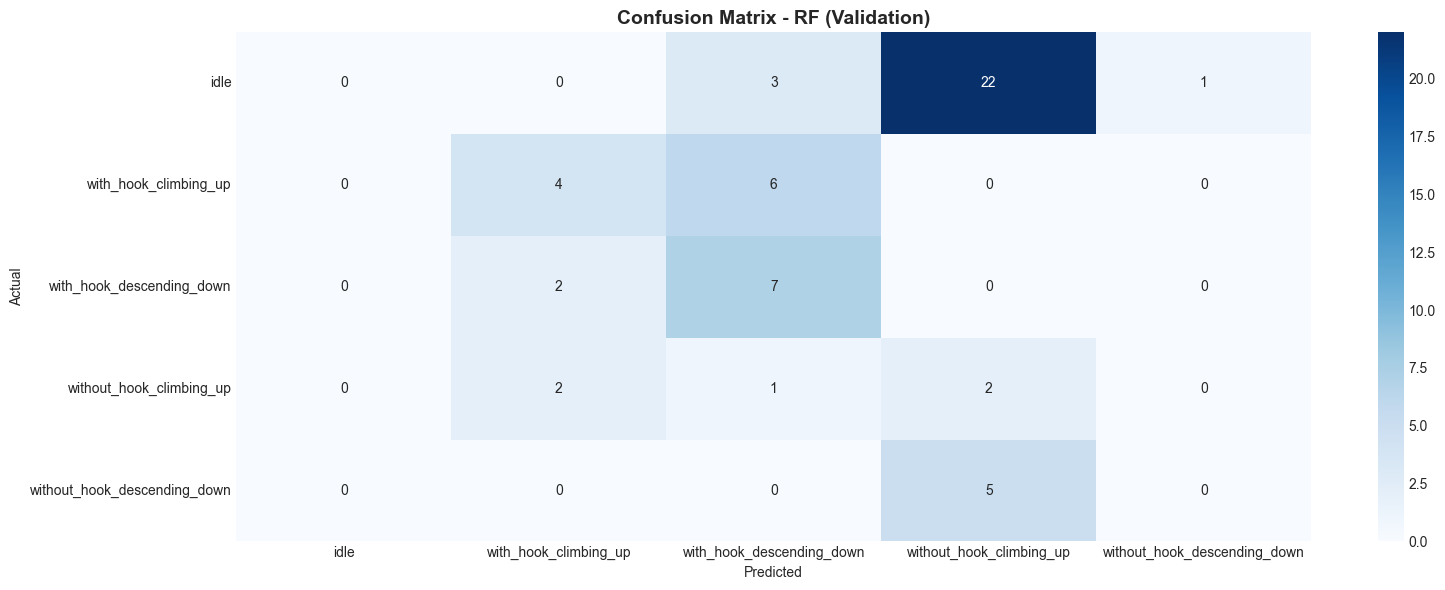

In [394]:
fig, axes = plt.subplots(figsize=(16, 6))

sns.heatmap(cm_rf_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_rf.classes_,
            yticklabels=model_rf.classes_,
            ax=axes)
axes.set_title('Confusion Matrix - RF (Validation)', fontsize=14, fontweight='bold')
axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Per-Class Performance Metrics

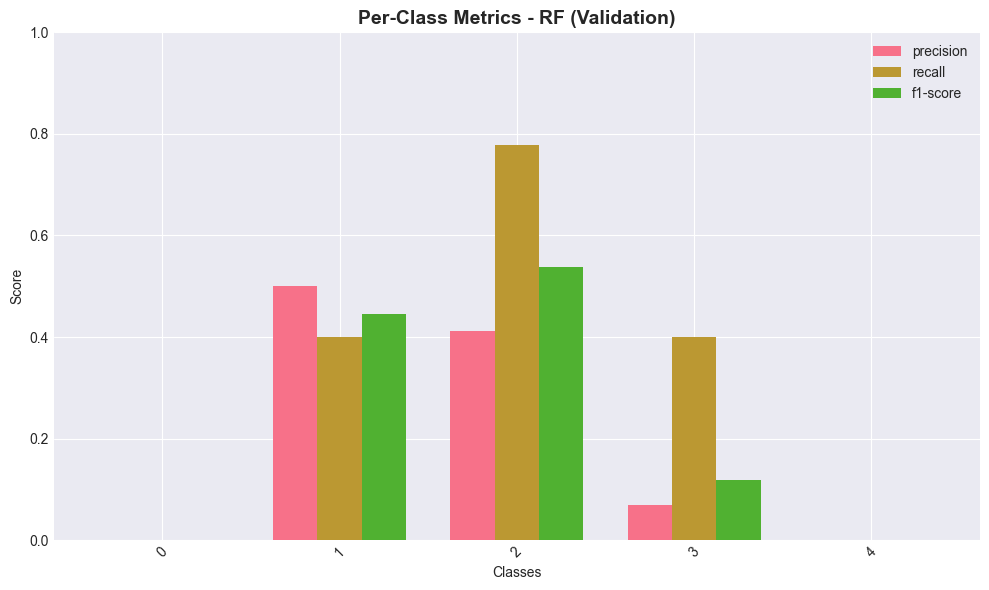

In [395]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['precision', 'recall', 'f1-score']
classes_rf = [c for c in results_df_rf_val.index if c not in ['accuracy', 'macro avg', 'weighted avg']]
x_pos = np.arange(len(classes_rf))

for i, metric in enumerate(metrics):
    values = [results_df_rf_val.loc[c, metric] for c in classes_rf]
    ax.bar(x_pos + i*0.25, values, width=0.25, label=metric)

ax.set_title("Per-Class Metrics - RF (Validation)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes")
ax.set_ylabel("Score")
ax.set_xticks(x_pos + 0.25)
ax.set_xticklabels(classes_rf, rotation=45)
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

Saving Files

In [239]:
joblib.dump(model_rf, "model_files/model_rf.pkl")
joblib.dump(scaler_rf, "model_files/scaler_rf.pkl")
joblib.dump(processor.label_encoder, "model_files/label_encoder.pkl")  # shared

size_rf_kb = os.path.getsize("model_files/model_rf.pkl") / 1024
print(f"Random Forest Model Size: {size_rf_kb:.2f} KB")

Random Forest Model Size: 420.72 KB
